In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

We set all the parameters we need

In [3]:
# Parameters
np.random.seed(42) # For reproducibility
N = 100  # Number of paths/simulations
T = 1  # Time horizon in years
dt = 1/N # Time interval
M = 100  # Number of time steps

tao = [0.1,0.2,0.3,0.5,0.7,1.0] #time to maturity grid
m = [0.1,0.3,0.7,1.0,1.5,2.0,5.0] # moneyness grid

S0 = 100  # Initial stock price
mu = 0.05
sigma = 0.2  # Volatility
r = 0.001 #interest rate

We simulate our paths with the assumption that arbitrage exists

In [4]:

# Simulate paths using Geometric Brownian Motion with Jumps
def StockPath():
    lambda_ = 10  # average number of jumps per year
    mu_j = -1    # average jump size
    sigma_j = 0.5  # jump size volatility

    S = np.zeros(M)
    S[0] = S0

    for i in range(1, M):
        Z = np.random.standard_normal()
        J = np.random.standard_normal() #jump
        N_j = np.random.poisson(lambda_ * dt) # number of jumps

        S[i] = S[i-1] * (np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) + N_j * (np.exp(mu_j + sigma_j * J) - 1))
    return S
#N samples each with M steps
S = np.zeros((N,M))
for i in range(N):
    S[i] = StockPath()

We strictly follow the steps outlined in the paper, where we use the BS Merton to calculate the penalty functions

In [5]:

# calculate c
def c(S,m,tao,r,sigma):
    d1 = (-np.log(m) + (r + 0.5 * (sigma**2)) * tao) / (sigma * np.sqrt(tao))
    d2 = d1 - sigma * np.sqrt(tao)
    grid = S * norm.cdf(d1) - m * S * np.exp(-r * tao) * norm.cdf(d2)
    return grid

# calculate penalty
def penalty_function(S,m,tao,r,sigma):
    p = 0
    l1 = len(m)
    l2=len(tao)
    for i in range(l1):
        for j in range(l2-1):
            temp1 = tao[j]*(c(S,m[i],tao[j],r,sigma)-c(S,m[i],tao[j+1],r,sigma))/(tao[j+1]-tao[j])
            p += (temp1>0) * temp1
    for i in range(l1-1):
        for j in range(l2):
            temp1 = (c(S,m[i+1],tao[j],r,sigma)-c(S,m[i],tao[j],r,sigma))/(m[i+1]-m[i])
            p += (temp1>0) * temp1

    for i in range(1,l1-1):
        for j in range(l2):
            temp1 = (c(S,m[i],tao[j],r,sigma)-c(S,m[i-1],tao[j],r,sigma))/(m[i]-m[i-1]) - (c(S,m[i+1],tao[j],r,sigma)-c(S,m[i],tao[j],r,sigma))/(m[i+1]-m[i])
            p += (temp1>0) * temp1
    return p

We count the number of simulations that is not arbitrage free

In [6]:
# penalties for initial sample
penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        penalties[i] += penalty_function(S[i][j],m,tao,0.1,0.5)

print(np.count_nonzero(penalties))

24


We choose a few beta to see how hard the arbitrage penalisation is and how that gives us arbitrage free new samples

In [7]:
b = 0.01 #beta is how much we are penalizing the arbitrage paths
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties)) #this is the reweighting
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0])) #we sample again according to the reweighting
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5) # we calculate the arbitrage penalties again for our new sample with re-estimated parameter
print(np.count_nonzero(re_penalties))
re = np.exp(-b*re_penalties)/np.nansum(np.exp(-b*re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))#relative entropy
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

14
-15.600059069465374
1.6940948873525872
4.655978864613573
99.84446743607768


In [12]:
b = 0.01
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties))
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0]))
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5)
print(np.count_nonzero(re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

13
-15.600059069465374
0.013638886701949236
1.6940948873525872
5.921174611578969


In [8]:
b = 0.1
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties))
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0]))
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5)
print(np.count_nonzero(re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

4
-18.885897517126523
0.0
0.0
4.459104885567936


<ipython-input-8-a2518bf5ecbd>:13: RuntimeWarning: divide by zero encountered in log
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
<ipython-input-8-a2518bf5ecbd>:13: RuntimeWarning: invalid value encountered in multiply
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))


In [9]:
b = 1
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties))
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0]))
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5)
print(np.count_nonzero(re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

5
-22.756504502817677
0.0
0.015264484546182388
0.30630393236183645


<ipython-input-9-df7beca1541c>:13: RuntimeWarning: divide by zero encountered in log
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
<ipython-input-9-df7beca1541c>:13: RuntimeWarning: invalid value encountered in multiply
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))


In [11]:
b = 10
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties))
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0]))
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5)
print(np.count_nonzero(re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

0
-25.78593336737822
0.0
0.0
0.0


<ipython-input-11-cb8f5eec0fa9>:13: RuntimeWarning: divide by zero encountered in log
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
<ipython-input-11-cb8f5eec0fa9>:13: RuntimeWarning: invalid value encountered in multiply
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))


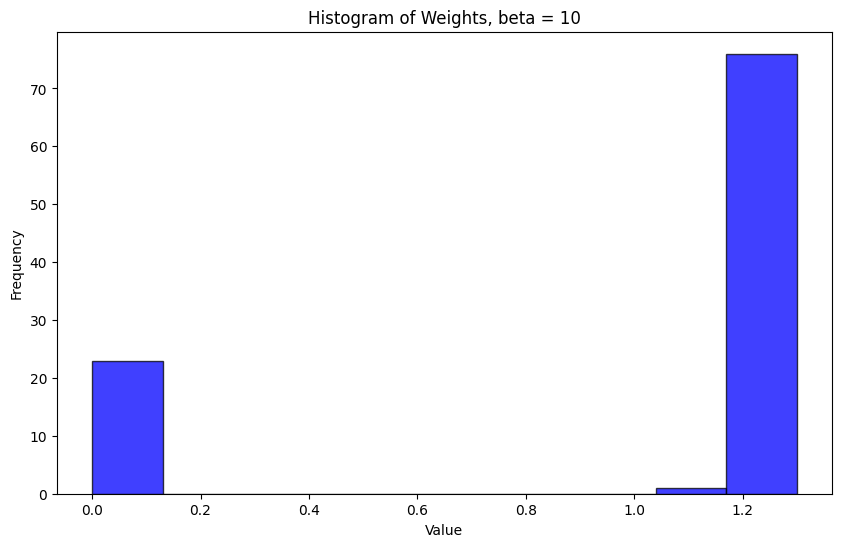

In [8]:


hist, bin_edges = np.histogram(N*new_penalties, bins=10)
plt.figure(figsize=(10, 6))
plt.hist(N*new_penalties, bins=10, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Weights, beta = 10')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [9]:
b = 100
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties))
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0]))
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5)
print(np.count_nonzero(re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

0
-26.650573251477113
0.0
0.0
0.0


<ipython-input-9-d858cea0f544>:13: RuntimeWarning: divide by zero encountered in log
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
<ipython-input-9-d858cea0f544>:13: RuntimeWarning: invalid value encountered in multiply
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))


In [10]:
b = 1000
new_penalties = np.exp(-b*penalties)/np.sum(np.exp(-b*penalties))
index = np.random.choice(np.arange(0, N), N, p=list(new_penalties[:,0]))
re_S = np.zeros((N,M))
for i in range(N):
    re_S[i] = S[index[i]]

re_penalties = np.zeros((N,1))
for i in range(N):
    for j in range(M):
        re_penalties[i] += penalty_function(re_S[i][j],m,tao,0.1,0.5)
print(np.count_nonzero(re_penalties))
e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
print(e)
print(np.quantile(re_penalties,0.9))
print(np.quantile(re_penalties,0.95))
print(np.quantile(re_penalties,0.99))

0
-27.44366158746709
0.0
0.0
0.0


<ipython-input-10-95387ac15311>:13: RuntimeWarning: divide by zero encountered in log
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
<ipython-input-10-95387ac15311>:13: RuntimeWarning: invalid value encountered in multiply
  e = - N * np.log(N) - N * np.nansum(new_penalties * np.log(new_penalties))
